Notebook for simulating HSC fringing

In [1]:
from LSSTFringe import Sky_rubin, utils, plot_utils
%pylab inline
import rubin_sim.utils.ObservationMetaData as ObsMeta 
from scipy.ndimage import gaussian_filter,gaussian_laplace
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats
from astropy.io import fits
import galsim
from scipy import interpolate
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

plot_utils.init_plot_style()
HSC_y_path = 'data/throughputs/HSC/y_HSC.txt'
HSC_qe_path = 'data/throughputs/HSC/qe_ccd_HSC.txt'

def load_txt(f_name):
    wlen = np.loadtxt(f_name,usecols=0)
    thr = np.loadtxt(f_name,usecols=1)
    
    return(wlen,thr)

HSC_y_wlen,HSC_y_thr  =load_txt(HSC_y_path)
HSC_qe_wlen,HSC_qe = load_txt(HSC_qe_path)

f_thr = interpolate.interp1d(HSC_y_wlen/10, HSC_y_thr)
f_qe = interpolate.interp1d(HSC_qe_wlen/10, HSC_qe,fill_value='extrapolate')


# Load interpolator

dbfile = open('data/Interpolator/HSC_200si.pkl', 'rb')  
HSC_interpolator_200si= pickle.load(dbfile)
dbfile.close()

dbfile = open('data/Interpolator/HSC_100si.pkl', 'rb')  
HSC_interpolator_100si= pickle.load(dbfile)
dbfile.close()



# load thickness map and interpolator
Fitting,uu,indices = utils.load_ccd_map('E2V-321')

Populating the interactive namespace from numpy and matplotlib


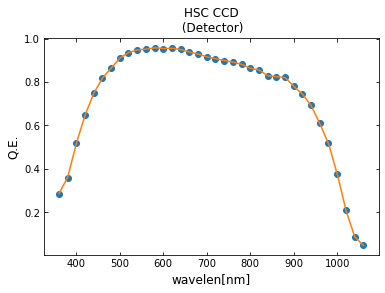

In [2]:
#plt.figure(figsize=(6,6))
wavelen = np.arange(HSC_qe_wlen[0]/10,HSC_qe_wlen[-1]/10,0.1)
plt.plot(HSC_qe_wlen/10,HSC_qe,'o')
plt.plot(wavelen,f_qe(wavelen))
plt.xlabel('wavelen[nm]',fontsize = 12)
plt.ylabel('Q.E.',fontsize = 12)
plt.title('HSC CCD\n (Detector)');

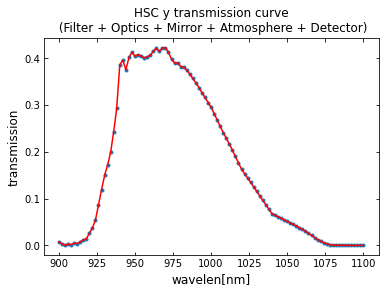

In [3]:
wavelen = np.arange(900,1100,0.1)
plt.title('HSC y transmission curve\n (Filter + Optics + Mirror + Atmosphere + Detector)')
plt.plot(HSC_y_wlen/10,HSC_y_thr,'.')
plt.plot(wavelen,f_thr(wavelen),'r')
plt.xlabel('wavelen[nm]',fontsize = 12)
plt.ylabel('transmission',fontsize = 12);

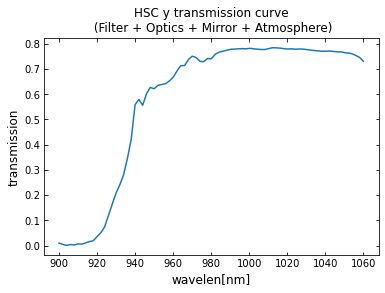

In [4]:
wavelen = np.arange(900,1060,0.1)
plt.title('HSC y transmission curve\n (Filter + Optics + Mirror + Atmosphere)')
plt.plot(wavelen,f_thr(wavelen)/f_qe(wavelen),'-')
plt.xlabel('wavelen[nm]',fontsize = 12)
plt.ylabel('transmission',fontsize = 12);

In [5]:
def generate_heightfield(fractal_dimension=2.5, n=100, seed=123):

    H = 1 - (fractal_dimension - 2)
    kpow = -(H + 1.0) / 2.0
    
    A = np.zeros((n, n), complex)

    kvec = np.fft.fftfreq(n)
    k0 = kvec[n // 64]
    kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
    ksq = kx ** 2 + ky ** 2
    m = ksq > 0

    gen = np.random.RandomState(seed=seed)    
    phase = 2 * np.pi * gen.uniform(size=(n, n))
    A[m] = ksq[m] ** kpow * gen.normal(size=(n, n))[m] * np.exp(1.j * phase[m]) * np.exp(-ksq[m] / k0 ** 2)
    #print(A.shape)
    
    return np.fft.ifft2(A)

(1042,)

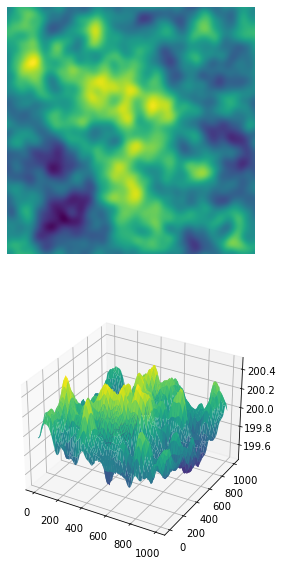

In [6]:

from mpl_toolkits import mplot3d
x = range(1000)
y = range(1000)
X, Y = np.meshgrid(x, y)


height_f2 = generate_heightfield(fractal_dimension= 2.55,n=1000,seed = 20).real
hf = plt.figure(figsize = (5,10))
scale_factor2 = 0.5/np.max(height_f2)
h2d = hf.add_subplot(211)
h2d.imshow(height_f2,interpolation='bicubic')
h2d.axis('off')
#cb = plt.colorbar()
#cb.set_label(label='Thickness (um)', size='large', weight='bold')
ha = hf.add_subplot(212, projection='3d')

ha.plot_surface(X, Y, height_f2*scale_factor2+200,cmap='viridis');

uu,indices = np.unique(np.round(height_f2*scale_factor2,3)+203,return_inverse=True)
uu.shape

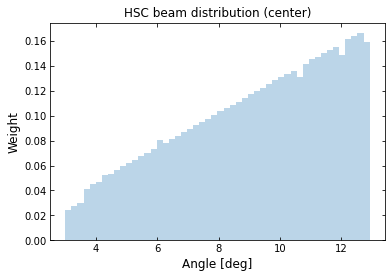

In [7]:
# Incident angle distribution and corresponding weight
hsc_angles_center,hsc_weight_center = utils.get_angle(theta_x=0.,theta_y=0.,Tele='HSC',plot=True)
plt.title('HSC beam distribution (center)')
plt.xlabel('Angle [deg]',fontsize = 12)
plt.ylabel('Weight',fontsize =12);

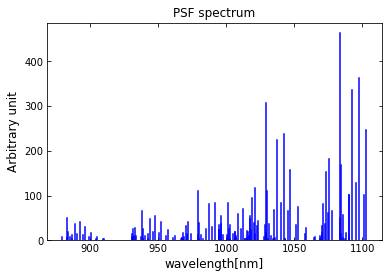

In [8]:
line_wlen,line_int,l =Sky_rubin.OHlines().load_skyline()
mask = (line_wlen > 908) & (line_wlen < 1061)
wavelengths = line_wlen[mask]

plot_utils.plot_line(line_wlen,line_int,color = 'b')
plt.title('PSF spectrum')
plt.xlabel('wavelength[nm]',fontsize = 12)
plt.ylabel('Arbitrary unit',fontsize = 12);

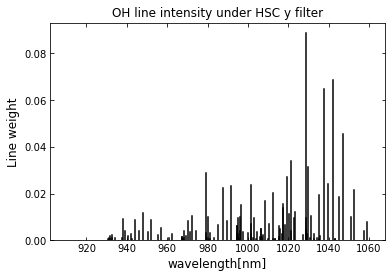

In [9]:
# Weight OH line unders HSC throughput
bandpass = f_thr(wavelengths)/f_qe(wavelengths)
tt_intensity = bandpass*wavelengths*line_int[mask]
line_weight = tt_intensity/np.sum(tt_intensity)
plot_utils.plot_line(wavelengths,line_weight,color = 'black')
plt.title('OH line intensity under HSC y filter')
plt.xlabel('wavelength[nm]',fontsize = 12)
#plt.axvspan(900,950,alpha = 0.2)
plt.ylabel('Line weight',fontsize = 12);

In [13]:
def sim (wavelengths,line_count,interp,angles,angle_weight):
    #sim_res = np.zeros(shape = Fitting.shape)
    sim_res = np.zeros(shape = (1000,1000))
    for wlen,count_num in zip(wavelengths,line_count):
        int_f = interp[str(wlen)]
        ss = int_f(uu,angles)
        #print(ss)
        sst = ss.T
        #print(ss)
        #print(sst.shape)
        total = np.sum(sst * angle_weight, axis = 1)
        final = total[indices]

        sim_res += count_num*final.reshape(1000,1000)
        #print(sim_res)
        
    return(sim_res)

# Define some plotting utility functions
def plot_tt_amp (sim_res,l):
    tt = sim_res
    plt.plot(np.diag(tt/np.mean(tt)-1)*100,label = l)
    plt.legend(loc = 'best')
    plt.axhline(0,ls = '--',color = 'black')
    plt.ylabel('Fringing amplitude (%)',fontsize = 12)  
    plt.xlabel('Diagonal pixel')
    
    
def get_lh (data,clip_percent = 1):
    lo, hi = np.percentile(
        data.ravel(), (0.5 * clip_percent, 100 - 0.5 * clip_percent))
    return(lo,hi)

In [11]:
HSC_sim_si_gaussian= sim(wavelengths= wavelengths,line_count=line_weight,
                         interp=HSC_interpolator_200si,angles = hsc_angles_center,angle_weight=hsc_weight_center)

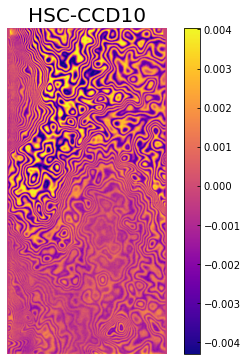

In [14]:
hdu = fits.open('data/HSC-Y/FRINGE-2017-09-13-HSC-Y-001.fits')
data = hdu[1].data
plt.figure(figsize = (6,6))
plt.title('HSC-CCD10',fontsize = 20)
lo,hi = get_lh(gaussian_filter(data, sigma= 4))

plt.imshow(gaussian_filter(data, sigma= 4),origin= 'lower',vmin=lo,vmax = hi,cmap='plasma')
plt.colorbar()
plt.axis('off');

(-0.4, 0.4)

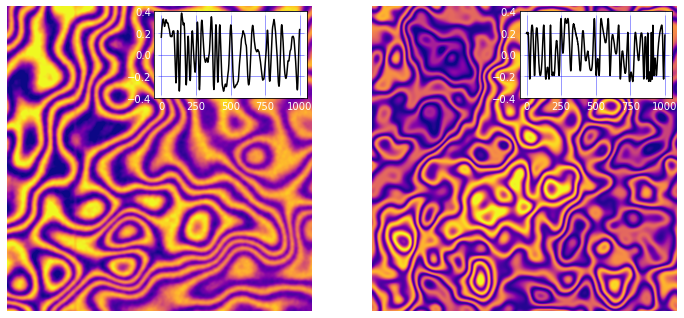

In [15]:
aaa = ((HSC_sim_si_gaussian/np.mean(HSC_sim_si_gaussian)-1)*100)
lo,hi = get_lh(aaa)
#plt.title('HSC Sim')

f,ax = plt.subplots(1,2,figsize = (12,6))
ax[1].imshow(((HSC_sim_si_gaussian/np.mean(HSC_sim_si_gaussian)-1)*100),origin = 'lower',vmin=lo,vmax=hi,cmap = 'plasma')
inner_ax = inset_axes(ax[1],
                        width="50%", # width = 30% of parent_bbox
                        height=1.2, # height : 1 inch
                        loc=1)
inner_ax.grid(c='b', ls='-', alpha=0.5)
inner_ax.plot(np.diag(aaa),'k-')
inner_ax.tick_params(axis='x', colors='w', labelsize=10)
inner_ax.tick_params(axis='y', colors='w', labelsize=10)
inner_ax.set_ylim(-0.4,0.4)
ax[1].axis('off')


A = gaussian_filter(data, sigma= 4)
lo,hi = get_lh(A*100)
ax[0].imshow(A[3000:-176,1000-200:-48-200]*100,origin = 'lower',vmin = lo, vmax = hi,cmap='plasma')
inner_ax2 = inset_axes(ax[0],
                        width="50%", # width = 30% of parent_bbox
                        height=1.2, # height : 1 inch
                        loc=1)
inner_ax2.grid(c='b', ls='-', alpha=0.5)
inner_ax2.plot(np.diag(A[3000:-176,1000:-48])*100,'k-')
inner_ax2.tick_params(axis='x', colors='w', labelsize=10)
inner_ax2.tick_params(axis='y', colors='w', labelsize=10)
ax[0].axis('off')
inner_ax2.set_ylim(-0.4,0.4)
#f.savefig('Paperplots/HSC-data-sim.eps')

Text(0, 0.5, 'Fringing amplitude (%)')

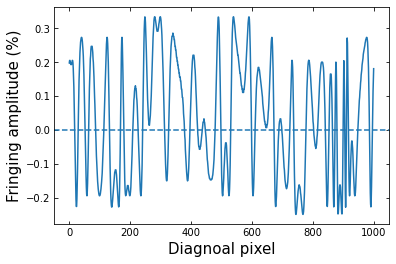

In [16]:
plt.figure(figsize = (6,4))
plt.plot(np.diag(aaa),'-')
plt.axhline(0,ls = '--')
plt.xlabel('Diagnoal pixel',fontsize = 15)
plt.ylabel('Fringing amplitude (%)',fontsize = 15)